In [12]:
# package installations

# !pip3 install numpy
# !pip3 install matplotlib
# !pip3 install tensorflow

In [13]:
# package imports

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [14]:
# importing the dataset using library func.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [15]:
# construct training set
X_train, Y_train = [], []
X_3, X_8 = [], []
Y_3, Y_8 = [], []

for i in range(x_train.shape[0]) :
    if(y_train[i] == 3) :
        X_3.append(x_train[i].flatten())
        Y_3.append(float(1))
    elif(y_train[i] == 8) :
        X_8.append(x_train[i].flatten())
        Y_8.append(float(-1))

training_size = 1000

training_indices_3 = random.sample(range(0, len(X_3)), int(training_size / 2))
training_indices_8 = random.sample(range(0, len(X_8)), int(training_size / 2))

# half of 3, half of 8
for i in training_indices_3:
    X_train.append(X_3[i])
    Y_train.append(Y_3[i])

for i in training_indices_8 :
    X_train.append(X_8[i])
    Y_train.append(Y_8[i])
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [16]:
# construct testing and validation set
X_validation, Y_validation = [], []
X_test, Y_test = [], []
        
validation_size = int((2 * training_size) / 3)
testing_size = int((2 * training_size) / 3)

X_total, Y_total = [], []
for i in range(x_test.shape[0]) :
    if(y_test[i] == 3) :
        X_total.append(x_test[i].flatten())
        Y_total.append(float(1))
    elif(y_test[i] == 8) :
        X_total.append(x_test[i].flatten())
        Y_total.append(float(-1))
        
X1, Y1 = [], []
        
validation_indices = random.sample(range(0, len(X_total)), validation_size)
for i in range(len(X_total)) :
    if(i in validation_indices) :
        X_validation.append(X_total[i])
        Y_validation.append(Y_total[i])
    else :
        X1.append(X_total[i])
        Y1.append(Y_total[i])

testing_indices = random.sample(range(0, len(X1)), testing_size) 
for i in testing_indices :
    X_test.append(X1[i])
    Y_test.append(Y1[i])
    
X_validation = np.array(X_validation)
X_test = np.array(X_test)

Y_validation = np.array(Y_validation)
Y_test = np.array(Y_test)

In [17]:
# divide each feature by 255 to normalize
X_train = np.divide(X_train, float(255))
X_validation = np.divide(X_validation, float(255))
X_test = np.divide(X_test, float(255))

In [18]:
# kernel functions 
def linear_kernel(x1, x2) :
    return np.matmul(np.transpose(x1), x2)

def polynomial_kernel(x1, x2, d=2) :
    return (np.matmul(np.transpose(x1), x2) + float(1)) ** d

def RBF_kernel(x1, x2, sigma=5) :
    return np.exp(- np.sum( np.power((x1 - x2),2) ) / float( 2*(sigma**2) ) )

In [19]:
# objective function 
def objective_function(X_train, Y_train, alpha, b, kernel, X_input) :
    ans = 0
    for i in range(X_train.shape[0]) :
        val = alpha[i] * Y_train[i] * kernel(X_train[i], X_input)
        ans = ans + val
    ans = ans + b
    
    return ans

# simplified objective function 
def simplified_objective_function(Y_train, alpha, b, kernel_matrix, index) :
    ans = 0
    for i in range(Y_train.shape[0]) :
        val = alpha[i] * Y_train[i] * kernel_matrix[i][index]
        ans = ans + val
    ans = ans + b
    
    return ans

# eta val 
def get_eta(i, j, kernel_matrix) :
    return (2 * kernel_matrix[i][j] - kernel_matrix[i][i] - kernel_matrix[j][j])

# get kernel matrix
def get_kernel_matrix(X_train, kernel) :
    kernel_matrix = np.zeros((X_train.shape[0], X_train.shape[0]))
    for i in range(X_train.shape[0]) :
        for j in range(X_train.shape[0]) :
            kernel_matrix[i][j] = kernel(X_train[i], X_train[j])
            
    return kernel_matrix

In [20]:
# obtain kernel Matrix
kernel_matrix = get_kernel_matrix(X_train, linear_kernel)

In [21]:
# global variables

tol = 0.001
err = 0.001
C = float(50)

alpha = np.zeros(X_train.shape[0])
b = float(0)
max_passes = 5

In [22]:
# smo
passes = 0
while(passes < max_passes) :
    num_changed_alphas = 0
    for i in range(X_train.shape[0]) :
        error_i = simplified_objective_function(Y_train, alpha, b, kernel_matrix, i) - Y_train[i]
        if((Y_train[i] * error_i < float(-1 * tol) and alpha[i] < C) or (Y_train[i] * error_i > tol and alpha[i] > 0)) :
            j = i
            while(j == i) :
                j = np.random.randint(0, X_train.shape[0])
            error_j = simplified_objective_function(Y_train, alpha, b, kernel_matrix, j) - Y_train[j]
            
            # save old alpha
            alpha_i_old = alpha[i]
            alpha_j_old = alpha[j]
            
            # calculate L, H
            if(Y_train[i] != Y_train[j]) :
                L = max(float(0), alpha[j] - alpha[i])
                H = min(C, C + alpha[j] - alpha[i])
            else :
                L = max(0, alpha[i] + alpha[j] - C)
                H = min(C, alpha[i] + alpha[j])
            
            if(L == H) :
                continue
            
            eta = get_eta(i, j, kernel_matrix)
            
            if(eta == 0) :
                continue
            
            # compute and clip new alpha_j value
            alpha_j_new = alpha_j_old - float((Y_train[j] * (error_i - error_j)) / eta)
            if(alpha_j_new > H) :
                alpha_j_new = H
            if(alpha_j_new < L) :
                alpha_j_new = L
            
            if(np.abs(alpha_j_new - alpha_j_old) < err) :
                continue
                
            alpha_i_new = alpha_i_old + (Y_train[i] * Y_train[j] * (alpha_j_old - alpha_j_new))
            
            # assign values now
            alpha[i] = alpha_i_new
            alpha[j] = alpha_j_new
            
            # compute b values 
            b1 = b - error_i - (Y_train[i] * (alpha_i_new - alpha_i_old) * kernel_matrix[i][i]) - (Y_train[j] * (alpha_j_new - alpha_j_old) * kernel_matrix[i][j])
            b2 = b - error_j - (Y_train[i] * (alpha_i_new - alpha_i_old) * kernel_matrix[i][j]) - (Y_train[j] * (alpha_j_new - alpha_j_old) * kernel_matrix[j][j])
            
            if(alpha_i_new > 0 and alpha_i_new < C) :
                b = b1
            elif(alpha_j_new > 0 and alpha_j_new < C) :
                b = b2
            else :
                b = float((b1 + b2) / float(2))
                
            num_changed_alphas += 1
            print(passes, num_changed_alphas)
        #end
    #end
    if(num_changed_alphas == 0) :
        passes += 1
    else :
        passes = 0
    
#end
            

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 

0 84
0 85
0 86
0 87
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 

0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0

0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0

0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 

0 4
0 5
0 1
0 2
0 3
0 1
0 2
0 3
0 1
0 2
0 3
0 4
0 5
0 6
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 1
0 2
0 3
0 4
0 5
0 6
0 1
0 2
0 3
0 4
0 1
0 2
0 3
0 1
0 2
0 1
0 2
0 3
0 4
0 5
0 1
0 2
0 3
0 1
0 2
0 3
0 4
0 1
0 2
0 1
0 2
0 3
0 1
0 2
0 1
0 1
0 2
0 3
0 4
0 1
0 2
0 1
0 1
0 2
0 3
0 4
0 5
0 1
0 2
0 3
0 4
0 5
0 1
0 2
0 3
0 1
0 2
0 3
0 4
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 1
0 2
0 3
0 4
0 5
0 6
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 1
0 2
0 3
0 1
0 2
0 3
0 1
0 2
0 3
0 1
0 2
0 3
0 4
0 5
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 1
0 1
0 2
0 3
0 4
0 5
0 6
0 1
0 2
0 1
0 2
0 3
0 4
0 1
0 1
0 2
0 3
0 4
0 1
0 2
0 3
0 4
0 1
0 1
0 2
0 3
0 1
0 2
0 3
0 4
0 1
0 2
0 3
0 1
0 2
0 1
0 2
0 3
0 1
0 2
0 3
0 4
0 5
0 1
0 2
1 1
1 2
1 3
1 4
0 1
0 2
0 3
0 1
0 1
0 2
0 1
0 1
0 2
0 3
1 1
1 2
1 3
0 1
0 1
0 2
0 1
0 2
0 3
0 4
0 1
0 2
0 3
0 1
0 1
0 2
0 3
0 4
0 5
0 6
0 1
0 2
0 3
0 1
0 2
0 3
0 4
0 1
0 2
0 1
0 2
0 3
0 1
0 2
0 3
0 4
0 1
0 2
0 3
0 4
0 1
0 1
0 1
0 2
0 3
0 1
0 2
0 1
0 2
0 1
0 2
0 1
0 2
0 3
0 1
0 2
0 3
0 4
0 1
0 2
0 3
0 1
0 2
0 3
0 4
0 1
0 1


In [23]:
# check for training samples 

total_correct = 0
for i in range(X_train.shape[0]) :
    val = objective_function(X_train, Y_train, alpha, b, linear_kernel, X_train[i])
    if(val >= 0 and Y_train[i] == 1) :
        total_correct += 1
    elif(val < 0 and Y_train[i] == -1) :
        total_correct += 1

In [24]:
# percentage accuracy 
print("percentage accuracy : ", (total_correct / X_train.shape[0]) * 100 )

percentage accuracy :  100.0


In [25]:
# check for training samples 

total_correct = 0
for i in range(X_validation.shape[0]) :
    val = objective_function(X_train, Y_train, alpha, b, linear_kernel, X_validation[i])
    if(val >= 0 and Y_validation[i] == 1) :
        total_correct += 1
    elif(val < 0 and Y_validation[i] == -1) :
        total_correct += 1

In [26]:
# percentage accuracy 
print("percentage accuracy : ", (total_correct / X_validation.shape[0]) * 100 )

percentage accuracy :  95.1951951951952


In [27]:
# check for testing samples 

total_correct = 0
for i in range(X_test.shape[0]) :
    val = objective_function(X_train, Y_train, alpha, b, linear_kernel, X_test[i])
    if(val >= 0 and Y_test[i] == 1) :
        total_correct += 1
    elif(val < 0 and Y_test[i] == -1) :
        total_correct += 1

In [28]:
# percentage accuracy 
print("percentage accuracy : ", (total_correct / X_test.shape[0]) * 100 )

percentage accuracy :  94.14414414414415


In [35]:
x_val = []
y_val = []

vals = np.zeros(X_validation.shape[0])
for i in range(X_validation.shape[0]) :
    vals[i] = objective_function(X_train, Y_train, alpha, b, RBF_kernel, X_validation[i])

# plotting roc curve
for n in np.linspace(-5, 5, 1000):
    tp, fp, fn, tn = 0, 0, 0, 0
    for i in range(X_validation.shape[0]) :
        val = vals[i]
        if(val >= n) :
            if(Y_validation[i] == 1) :
                tp += 1
            else :
                fp += 1
        else :
            if(Y_validation[i] == 1) :
                fn += 1
            else :
                tn += 1
        
    tpr = float(tp) / float(tp + fn)
    fpr = float(fp) / float(fp + tn)
        
    x_val.append(fpr)
    y_val.append(tpr)

In [36]:
x_val.reverse()
y_val.reverse()

Text(0.5, 1.0, 'ROC Curve')

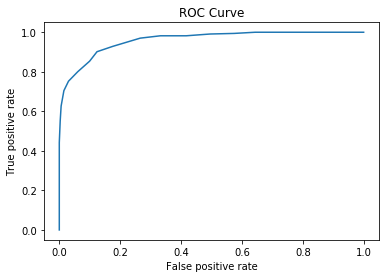

In [37]:
plt.plot(x_val, y_val)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")